In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Input file path
RAW_DATA = Path("/content/colorado_motor_vehicle_sales.csv")

# Output cleaned file path
CLEAN_DATA = Path('../data/processed/sales_cleaned.csv')
CLEAN_DATA.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
df = pd.read_csv(RAW_DATA)

print("Shape:", df.shape)
df.head()


Shape: (501, 4)


,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [ ]:
df.columns = [col.strip().title() for col in df.columns]
df.head()


In [ ]:
print(df.info())
print("\nMissing values:\n", df.isna().sum())
df.describe()
def parse_sales(x):
    """Parse sales values by removing symbols and converting to float."""
    if pd.isna(x):
        return np.nan
    try:
        return float(x)
    except:
        s = str(x)
        s = re.sub(r"[^0-9.\-]", "", s)
        return float(s) if s else np.nan

df['Sales_raw'] = df['Sales']
df['Sales'] = df['Sales'].apply(parse_sales)

df['Sales'].describe()


In [ ]:
def normalize_quarter(q):
    return f"Q{int(q)}" if pd.notna(q) else np.nan

df['Quarter'] = df['Quarter'].apply(normalize_quarter)
df['Quarter'].unique()



In [ ]:
quarter_to_month = {'Q1':1,'Q2':4,'Q3':7,'Q4':10}
df['Month'] = df['Quarter'].map(quarter_to_month)

df['Date'] = pd.to_datetime(dict(
    year=df['Year'],
    month=df['Month'],
    day=1
))
df.head()


In [ ]:
df = df.sort_values(['County','Date']).reset_index(drop=True)

df['Sales'] = df.groupby('County')['Sales'].apply(lambda x: x.interpolate(limit_direction='both'))

# Fill remaining with county median → global median
df['Sales'] = df.groupby('County')['Sales'].apply(lambda x: x.fillna(x.median()))
df['Sales'] = df['Sales'].fillna(df['Sales'].median())


In [ ]:
df['County'] = df['County'].astype(str).str.strip().str.title()
df['County'].unique()[:10]


In [ ]:
print("Final shape:", df.shape)
print("Missing values:\n", df.isna().sum())
df.head()


In [ ]:
df.to_csv(CLEAN_DATA, index=False)
print("Cleaned file saved at:", CLEAN_DATA)


Cleaned file saved at: ../data/processed/sales_cleaned.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

DATA = Path("/content/sales_cleaned.csv")
OUT_FIG = Path("../outputs/figures")
OUT_FIG.mkdir(parents=True, exist_ok=True)


In [10]:
df = pd.read_csv(DATA, parse_dates=["Date"])
df.head()


ValueError: Missing column provided to 'parse_dates': 'Date'

In [1]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())
print("\nDate range:", df["Date"].min(), "to", df["Date"].max())
print("\nCounties:", df["County"].nunique())


In [1]:
state_q = df.groupby("Date", as_index=False)["Sales"].sum().sort_values("Date")
state_q["Rolling4"] = state_q["Sales"].rolling(4).mean()

plt.plot(state_q["Date"], state_q["Sales"], label="Sales")
plt.plot(state_q["Date"], state_q["Rolling4"], label="4Q Rolling", linestyle="--")
plt.title("Statewide Quarterly Motor Vehicle Sales")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.grid(True)
plt.savefig(OUT_FIG / "statewide_timeseries.png")
plt.show()


In [3]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Quarter", y="Sales", data=df)
plt.title("Sales Distribution by Quarter")
plt.savefig(OUT_FIG / "quarterly_boxplot.png")
plt.show()



NameError: name 'df' is not defined

<Figure size 800x500 with 0 Axes>

In [2]:
county_totals = df.groupby("County", as_index=False)["Sales"].sum().sort_values("Sales", ascending=False)

plt.bar(county_totals["County"].head(10), county_totals["Sales"].head(10))
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Counties by Total Sales")
plt.ylabel("Total Sales (USD)")
plt.savefig(OUT_FIG / "top10_counties.png")
plt.show()

county_totals.head(10)


NameError: name 'df' is not defined

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Paths
RAW_DATA = Path("/content/colorado_motor_vehicle_sales.csv")
CLEAN_DATA = Path("/content/sales_cleaned.csv")
CLEAN_DATA.parent.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. LOAD RAW DATA
# ============================================================
df = pd.read_csv(RAW_DATA)
print("Raw shape:", df.shape)
display(df.head())

# ============================================================
# 2. STANDARDIZE COLUMN NAMES
# ============================================================
df.columns = [col.strip().title() for col in df.columns]
print("Columns after normalization:", df.columns.tolist())
display(df.head())

# ============================================================
# 3. DATASET AUDIT — NULLS, TYPES, DISTRIBUTION
# ============================================================
print(df.info())
print("\nMissing values:\n", df.isna().sum())
display(df.describe())

# ============================================================
# 4. CLEAN SALES COLUMN
# ============================================================
def parse_sales(x):
    """Convert sales values to float safely."""
    if pd.isna(x):
        return np.nan
    try:
        return float(x)
    except:
        s = str(x)
        s = re.sub(r"[^0-9.\-]", "", s)
        return float(s) if s else np.nan

df["Sales_raw"] = df["Sales"]
df["Sales"] = df["Sales"].apply(parse_sales)
display(df["Sales"].describe())

# ============================================================
# 5. NORMALIZE QUARTER VALUES
# ============================================================
def normalize_quarter(q):
    return f"Q{int(q)}" if pd.notna(q) else np.nan

df["Quarter"] = df["Quarter"].apply(normalize_quarter)
print("Quarter values:", df["Quarter"].unique())

# ============================================================
# 6. CREATE DATE COLUMN (Year + Quarter)
# ============================================================
quarter_to_month = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}
df["Month"] = df["Quarter"].map(quarter_to_month)

df["Date"] = pd.to_datetime(dict(
    year=df["Year"],
    month=df["Month"],
    day=1
))

display(df.head())

# ============================================================
# 7. SORT + INTERPOLATE SALES PER COUNTY
# ============================================================
df = df.sort_values(["County", "Date"]).reset_index(drop=True)

df["Sales"] = df.groupby("County")["Sales"].transform(
    lambda x: x.interpolate(limit_direction="both")
)

df["Sales"] = df.groupby("County")["Sales"].transform(
    lambda x: x.fillna(x.median())
)

df["Sales"] = df["Sales"].fillna(df["Sales"].median())

print("Missing values after cleaning:\n", df.isna().sum())
display(df.head())

# ============================================================
# 8. CLEAN COUNTY COLUMN
# ============================================================
df["County"] = df["County"].astype(str).str.strip().str.title()
print("Sample counties:", df["County"].unique()[:10])

# ============================================================
# 9. FINAL AUDIT
# ============================================================
print("Final cleaned shape:", df.shape)
print("\nFinal Missing values:\n", df.isna().sum())
display(df.head())

# ============================================================
# 10. SAVE CLEANED DATASET
# ============================================================
df.to_csv(CLEAN_DATA, index=False)
print("Cleaned dataset saved to:", CLEAN_DATA)

Raw shape: (501, 4)


,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


Columns after normalization: ['Year', 'Quarter', 'County', 'Sales']


,Year,Quarter,County,Sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     501 non-null    int64 
 1   Quarter  501 non-null    int64 
 2   County   501 non-null    object
 3   Sales    501 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB
None

Missing values:
 Year       0
Quarter    0
County     0
Sales      0
dtype: int64


,Year,Quarter,Sales
count,501.000000,501.000000,5.010000e+02
mean,2011.570858,2.502994,1.760585e+08
std,2.266599,1.120041,1.642055e+08
min,2008.000000,1.000000,6.274000e+06
25%,2010.000000,2.000000,6.148200e+07
50%,2012.000000,3.000000,1.385820e+08
75%,2014.000000,4.000000,2.241580e+08
max,2015.000000,4.000000,9.169100e+08


,Sales
count,5.010000e+02
mean,1.760585e+08
std,1.642055e+08
min,6.274000e+06
25%,6.148200e+07
50%,1.385820e+08
75%,2.241580e+08
max,9.169100e+08


Quarter values: ['Q1' 'Q2' 'Q3' 'Q4']


,Year,Quarter,County,Sales,Sales_raw,Month,Date
0,2008,Q1,Adams,231609000.0,231609000,1,2008-01-01
1,2008,Q1,Arapahoe,550378000.0,550378000,1,2008-01-01
2,2008,Q1,Boulder/Broomfield,176771000.0,176771000,1,2008-01-01
3,2008,Q1,Denver,200103000.0,200103000,1,2008-01-01
4,2008,Q1,Douglas,93259000.0,93259000,1,2008-01-01


Missing values after cleaning:
 Year         0
Quarter      0
County       0
Sales        0
Sales_raw    0
Month        0
Date         0
dtype: int64


,Year,Quarter,County,Sales,Sales_raw,Month,Date
0,2008,Q1,Adams,231609000.0,231609000,1,2008-01-01
1,2008,Q2,Adams,241925000.0,241925000,4,2008-04-01
2,2008,Q3,Adams,204716000.0,204716000,7,2008-07-01
3,2008,Q4,Adams,162708000.0,162708000,10,2008-10-01
4,2009,Q1,Adams,147150000.0,147150000,1,2009-01-01


Sample counties: ['Adams' 'Arapahoe' 'Boulder' 'Boulder/Broomfield' 'Broomfield' 'Denver'
 'Douglas' 'El Paso' 'Fremont' 'Garfield']
Final cleaned shape: (501, 7)

Final Missing values:
 Year         0
Quarter      0
County       0
Sales        0
Sales_raw    0
Month        0
Date         0
dtype: int64


,Year,Quarter,County,Sales,Sales_raw,Month,Date
0,2008,Q1,Adams,231609000.0,231609000,1,2008-01-01
1,2008,Q2,Adams,241925000.0,241925000,4,2008-04-01
2,2008,Q3,Adams,204716000.0,204716000,7,2008-07-01
3,2008,Q4,Adams,162708000.0,162708000,10,2008-10-01
4,2009,Q1,Adams,147150000.0,147150000,1,2009-01-01


Cleaned dataset saved to: /content/sales_cleaned.csv


Shape: (501, 7)


,Year,Quarter,County,Sales,Sales_raw,Month,Date
0,2008,Q1,Adams,231609000.0,231609000,1,2008-01-01
1,2008,Q2,Adams,241925000.0,241925000,4,2008-04-01
2,2008,Q3,Adams,204716000.0,204716000,7,2008-07-01
3,2008,Q4,Adams,162708000.0,162708000,10,2008-10-01
4,2009,Q1,Adams,147150000.0,147150000,1,2009-01-01


Columns: ['Year', 'Quarter', 'County', 'Sales', 'Sales_raw', 'Month', 'Date']

Missing values:
 Year         0
Quarter      0
County       0
Sales        0
Sales_raw    0
Month        0
Date         0
dtype: int64

Date range: 2008-01-01 00:00:00 to 2015-10-01 00:00:00

Total counties: 17


,Year,Sales,Sales_raw,Month,Date
count,501.000000,5.010000e+02,5.010000e+02,501.000000,501
mean,2011.570858,1.760585e+08,1.760585e+08,5.508982,2011-12-12 02:06:28.023952128
min,2008.000000,6.274000e+06,6.274000e+06,1.000000,2008-01-01 00:00:00
25%,2010.000000,6.148200e+07,6.148200e+07,4.000000,2010-01-01 00:00:00
50%,2012.000000,1.385820e+08,1.385820e+08,7.000000,2012-01-01 00:00:00
75%,2014.000000,2.241580e+08,2.241580e+08,10.000000,2014-01-01 00:00:00
max,2015.000000,9.169100e+08,9.169100e+08,10.000000,2015-10-01 00:00:00
std,2.266599,1.642055e+08,1.642055e+08,3.360122,NaN


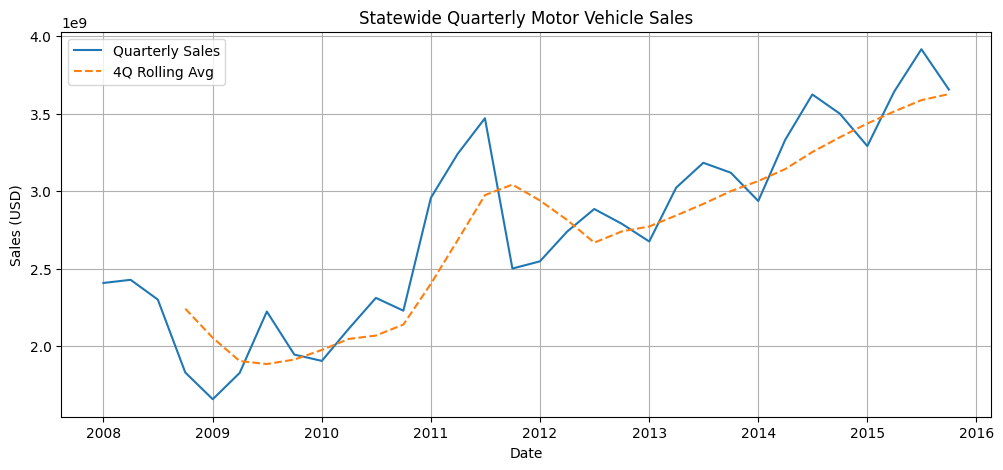

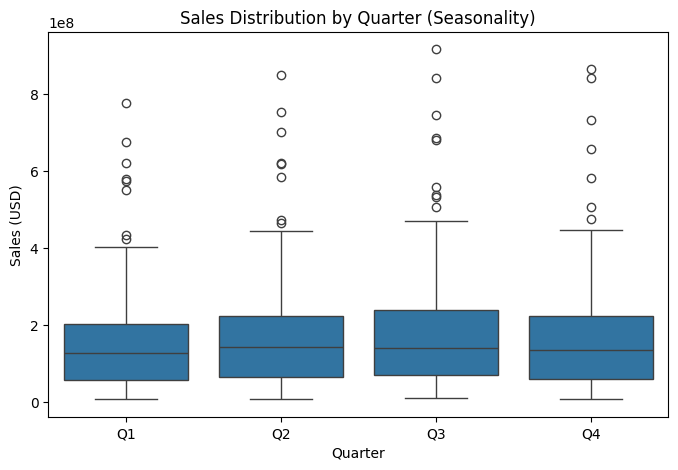

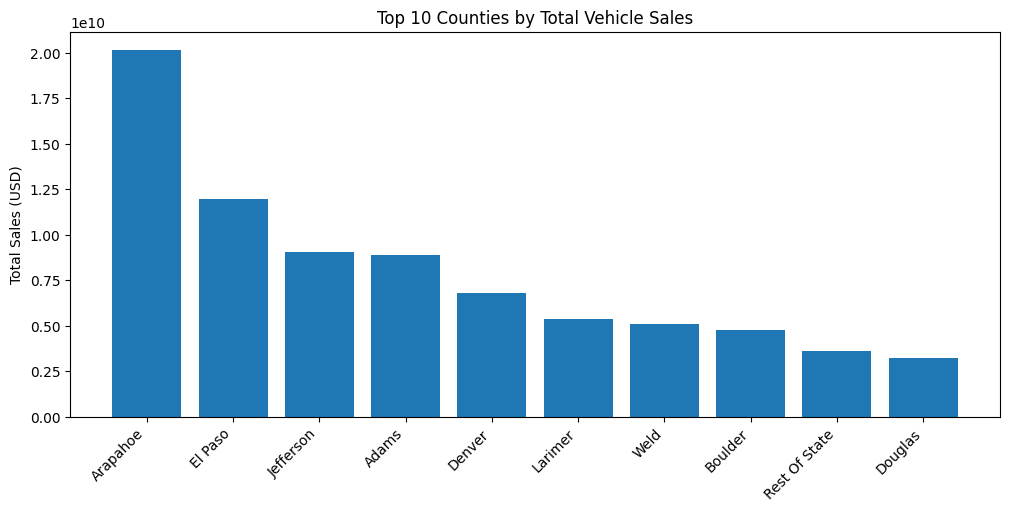

,County,Sales
1,Arapahoe,2.014232e+10
7,El Paso,1.192604e+10
10,Jefferson,9.058407e+09
0,Adams,8.902115e+09
5,Denver,6.763613e+09
12,Larimer,5.344367e+09
16,Weld,5.086889e+09
2,Boulder,4.742532e+09
15,Rest Of State,3.582170e+09
6,Douglas,3.236493e+09


Recent Growth (QoQ & YoY):


,Date,Sales,Rolling4,QoQ_pct,YoY_pct
22,2013-07-01,3.183370e+09,2.917784e+09,5.322659,10.340699
23,2013-10-01,3.119365e+09,3.000154e+09,-2.010605,11.809686
24,2014-01-01,2.936644e+09,3.065468e+09,-5.857634,9.765204
25,2014-04-01,3.331042e+09,3.142605e+09,13.430229,10.208427
26,2014-07-01,3.624346e+09,3.252849e+09,8.805173,13.852490
27,2014-10-01,3.500455e+09,3.348122e+09,-3.418299,12.216910
28,2015-01-01,3.291273e+09,3.436779e+09,-5.975852,12.075996
29,2015-04-01,3.642834e+09,3.514727e+09,10.681612,9.360194
30,2015-07-01,3.916440e+09,3.587750e+09,7.510801,8.059220
31,2015-10-01,3.656185e+09,3.626683e+09,-6.645193,4.448850


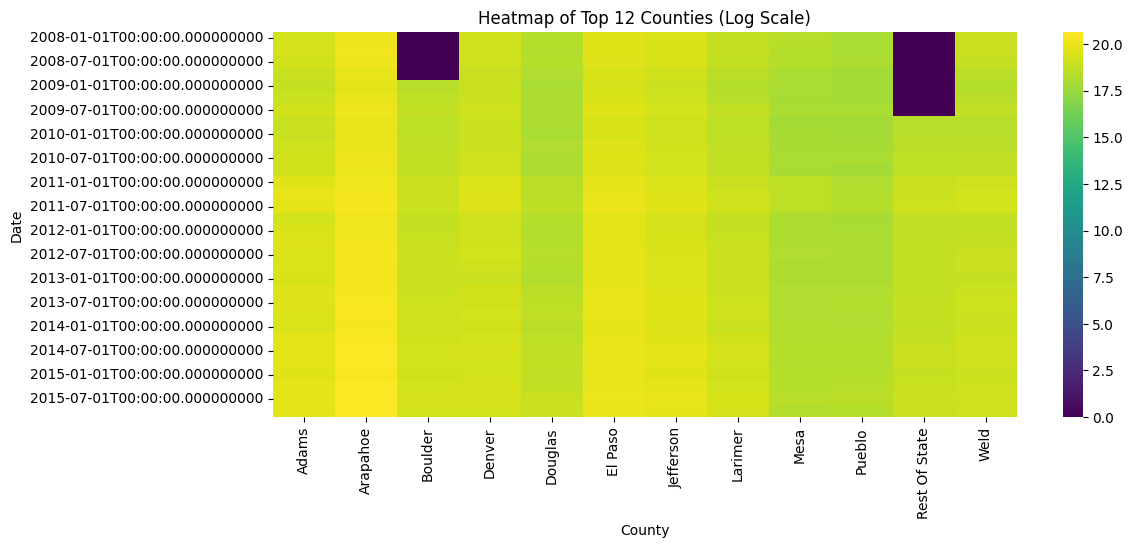

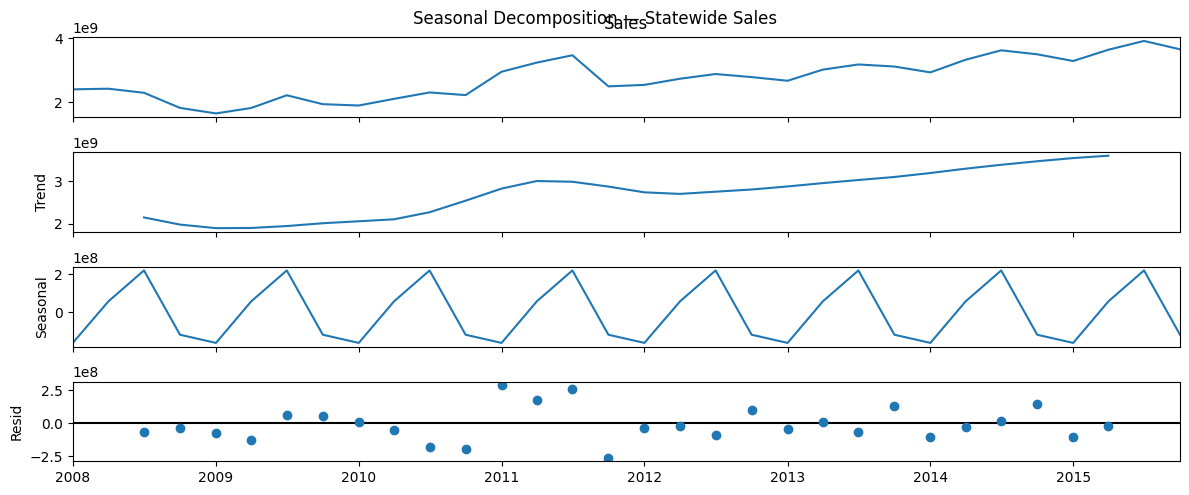

Phase 2 EDA Completed.
Figures saved in: /content/outputs/figures


In [20]:
# ============================================================
# PHASE 2 — EXPLORATORY DATA ANALYSIS (FULL NOTEBOOK)
# File: notebooks/02_phase2_eda.ipynb
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

# Paths
DATA = Path("/content/sales_cleaned.csv")
OUT_FIG = Path("/content/outputs/figures")
OUT_FIG.mkdir(parents=True, exist_ok=True)


# ============================================================
# 1. LOAD CLEANED DATA
# ============================================================

df = pd.read_csv(DATA)
# Convert 'Date' column to datetime after loading
df['Date'] = pd.to_datetime(df['Date'])
print("Shape:", df.shape)
display(df.head())


# ============================================================
# 2. DATASET OVERVIEW
# ============================================================

print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())
print("\nDate range:", df["Date"].min(), "to", df["Date"].max())
print("\nTotal counties:", df["County"].nunique())
display(df.describe())


# ============================================================
# 3. STATEWIDE QUARTERLY TREND
# ============================================================

state_q = df.groupby("Date", as_index=False)["Sales"].sum().sort_values("Date")
state_q["Rolling4"] = state_q["Sales"].rolling(4).mean()

plt.plot(state_q["Date"], state_q["Sales"], label="Quarterly Sales")
plt.plot(state_q["Date"], state_q["Rolling4"], label="4Q Rolling Avg", linestyle="--")
plt.title("Statewide Quarterly Motor Vehicle Sales")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.grid(True)
plt.legend()
plt.savefig(OUT_FIG / "statewide_timeseries.png")
plt.show()


# ============================================================
# 4. QUARTERLY SEASONALITY (BOXPLOT)
# ============================================================

plt.figure(figsize=(8,5))
sns.boxplot(x="Quarter", y="Sales", data=df)
plt.title("Sales Distribution by Quarter (Seasonality)")
plt.xlabel("Quarter")
plt.ylabel("Sales (USD)")
plt.savefig(OUT_FIG / "quarterly_boxplot.png")
plt.show()


# ============================================================
# 5. TOP 10 COUNTIES BY TOTAL SALES
# ============================================================

county_totals = df.groupby("County", as_index=False)["Sales"].sum().sort_values("Sales", ascending=False)

plt.bar(county_totals["County"].head(10), county_totals["Sales"].head(10))
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Counties by Total Vehicle Sales")
plt.ylabel("Total Sales (USD)")
plt.savefig(OUT_FIG / "top10_counties.png")
plt.show()

display(county_totals.head(10))


# ============================================================
# 6. GROWTH RATES — QoQ & YoY
# ============================================================

state_q["QoQ_pct"] = state_q["Sales"].pct_change() * 100
state_q["YoY_pct"] = state_q["Sales"].pct_change(4) * 100

print("Recent Growth (QoQ & YoY):")
display(state_q.tail(10))

state_q.to_csv("../outputs/statewide_with_growth.csv", index=False)


# ============================================================
# 7. HEATMAP — TOP 12 COUNTIES OVER TIME
# ============================================================

top12 = county_totals["County"].head(12)
df_top12 = df[df["County"].isin(top12)]

pivot = df_top12.pivot_table(
    index="Date",
    columns="County",
    values="Sales",
    aggfunc="sum"
).fillna(0)

sns.heatmap(np.log1p(pivot), cmap="viridis")
plt.title("Heatmap of Top 12 Counties (Log Scale)")
plt.savefig(OUT_FIG / "heatmap_top12.png")
plt.show()


# ============================================================
# 8. SEASONAL DECOMPOSITION (STATEWIDE)
# ============================================================

ts = state_q.set_index("Date")["Sales"].asfreq("QS")
result = seasonal_decompose(ts, model="additive", period=4)

result.plot()
plt.suptitle("Seasonal Decomposition — Statewide Sales")
plt.savefig(OUT_FIG / "seasonal_decompose.png")
plt.show()


# ============================================================
# 9. PHASE 2 COMPLETE
# ============================================================

print("Phase 2 EDA Completed.")
print("Figures saved in:", OUT_FIG)

Shape: (501, 7)


,Year,Quarter,County,Sales,Sales_raw,Month,Date
0,2008,Q1,Adams,231609000.0,231609000,1,2008-01-01
1,2008,Q2,Adams,241925000.0,241925000,4,2008-04-01
2,2008,Q3,Adams,204716000.0,204716000,7,2008-07-01
3,2008,Q4,Adams,162708000.0,162708000,10,2008-10-01
4,2009,Q1,Adams,147150000.0,147150000,1,2009-01-01


Columns: ['Year', 'Quarter', 'County', 'Sales', 'Sales_raw', 'Month', 'Date']

Missing values:
 Year         0
Quarter      0
County       0
Sales        0
Sales_raw    0
Month        0
Date         0
dtype: int64

Date range: 2008-01-01 00:00:00 to 2015-10-01 00:00:00

Total counties: 17


,Year,Sales,Sales_raw,Month,Date
count,501.000000,5.010000e+02,5.010000e+02,501.000000,501
mean,2011.570858,1.760585e+08,1.760585e+08,5.508982,2011-12-12 02:06:28.023952128
min,2008.000000,6.274000e+06,6.274000e+06,1.000000,2008-01-01 00:00:00
25%,2010.000000,6.148200e+07,6.148200e+07,4.000000,2010-01-01 00:00:00
50%,2012.000000,1.385820e+08,1.385820e+08,7.000000,2012-01-01 00:00:00
75%,2014.000000,2.241580e+08,2.241580e+08,10.000000,2014-01-01 00:00:00
max,2015.000000,9.169100e+08,9.169100e+08,10.000000,2015-10-01 00:00:00
std,2.266599,1.642055e+08,1.642055e+08,3.360122,NaN


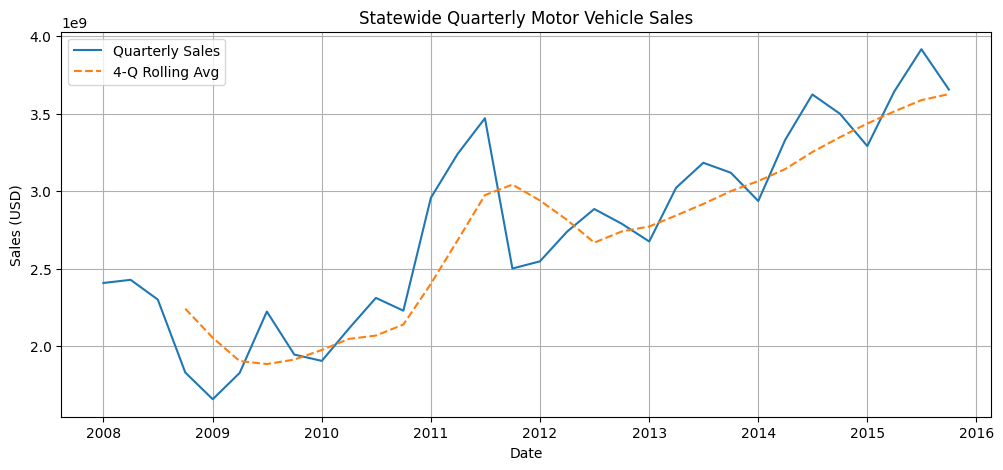

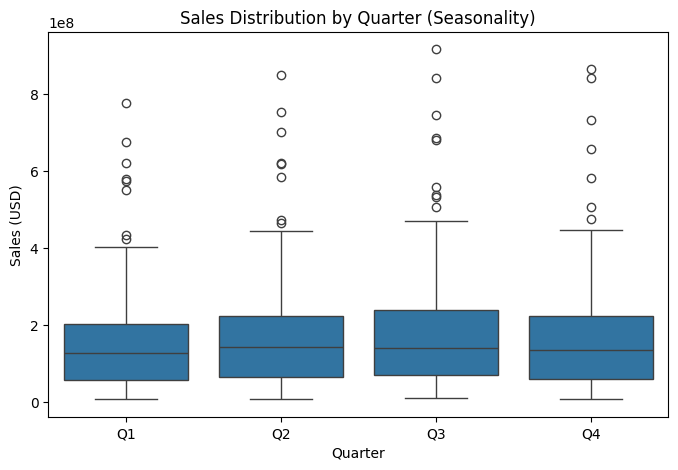

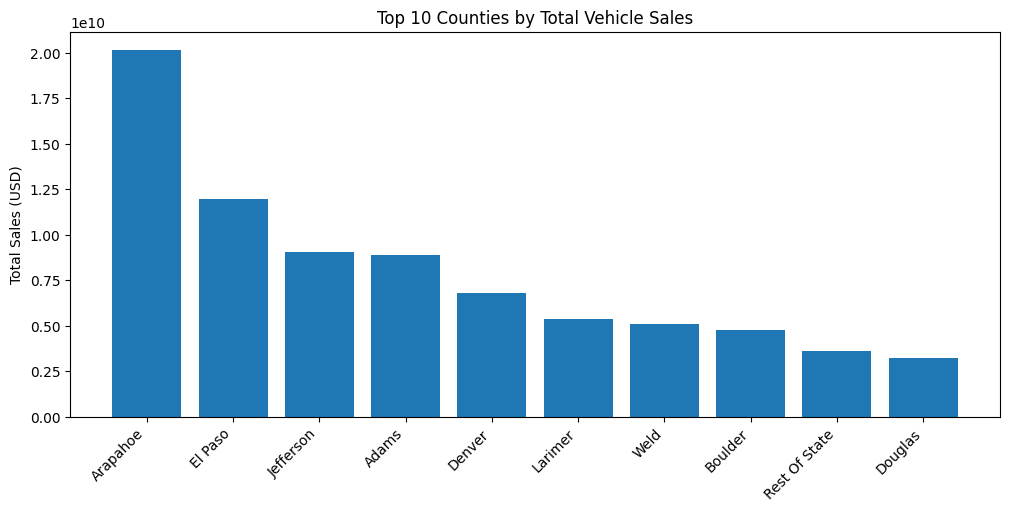

,County,Sales
1,Arapahoe,2.014232e+10
7,El Paso,1.192604e+10
10,Jefferson,9.058407e+09
0,Adams,8.902115e+09
5,Denver,6.763613e+09
12,Larimer,5.344367e+09
16,Weld,5.086889e+09
2,Boulder,4.742532e+09
15,Rest Of State,3.582170e+09
6,Douglas,3.236493e+09


Recent Growth (QoQ & YoY):


,Date,Sales,Rolling4,QoQ_pct,YoY_pct
22,2013-07-01,3.183370e+09,2.917784e+09,5.322659,10.340699
23,2013-10-01,3.119365e+09,3.000154e+09,-2.010605,11.809686
24,2014-01-01,2.936644e+09,3.065468e+09,-5.857634,9.765204
25,2014-04-01,3.331042e+09,3.142605e+09,13.430229,10.208427
26,2014-07-01,3.624346e+09,3.252849e+09,8.805173,13.852490
27,2014-10-01,3.500455e+09,3.348122e+09,-3.418299,12.216910
28,2015-01-01,3.291273e+09,3.436779e+09,-5.975852,12.075996
29,2015-04-01,3.642834e+09,3.514727e+09,10.681612,9.360194
30,2015-07-01,3.916440e+09,3.587750e+09,7.510801,8.059220
31,2015-10-01,3.656185e+09,3.626683e+09,-6.645193,4.448850


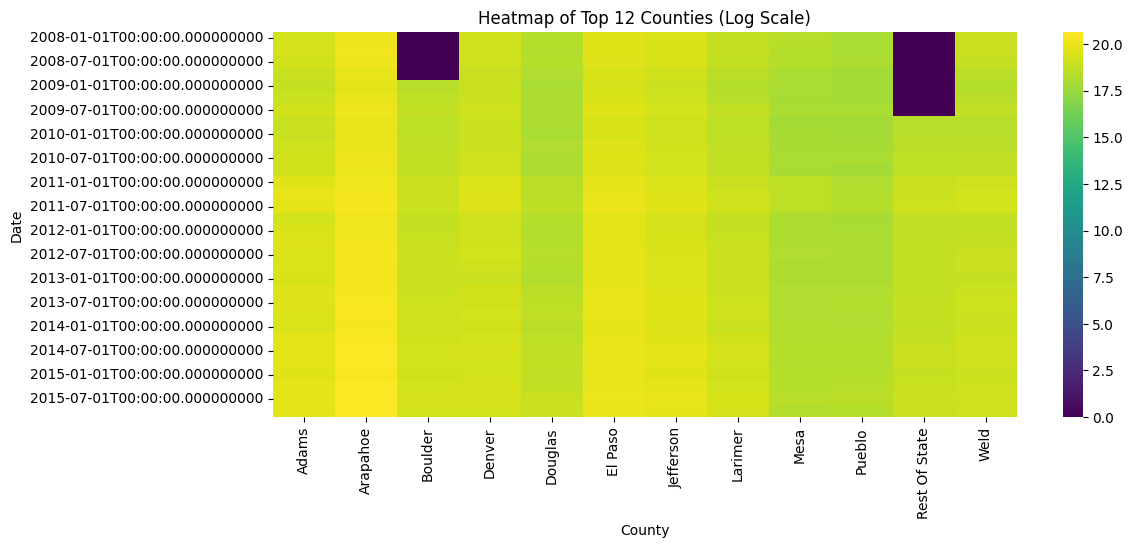

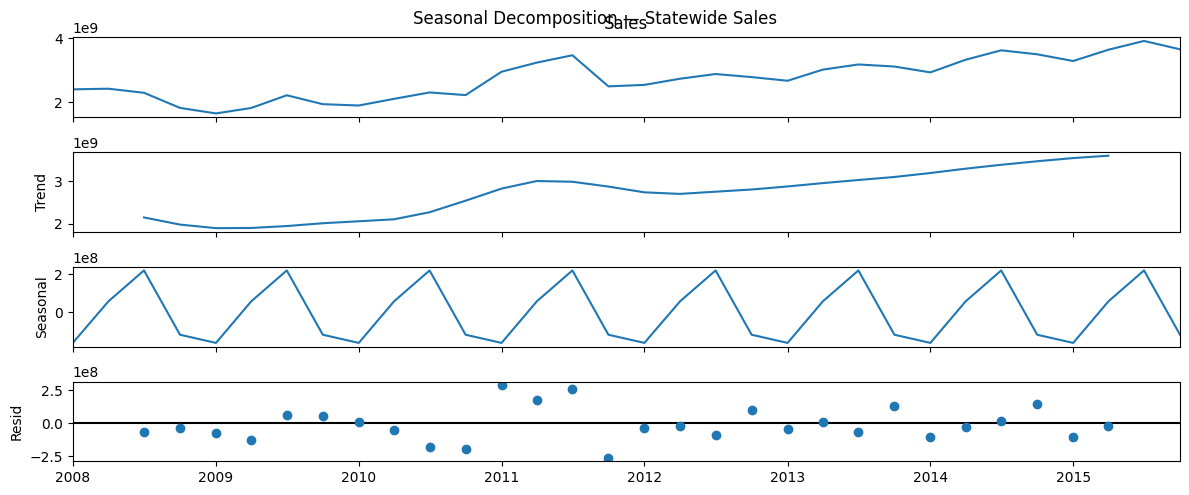

Phase 2 EDA Completed.
Figures saved in: /content/outputs/figures


In [21]:
# ============================================================
# PHASE 2 — EXPLORATORY DATA ANALYSIS (FULL NOTEBOOK)
# File: notebooks/02_phase2_eda.ipynb
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

# Paths
DATA = Path("/content/sales_cleaned.csv")
OUT_FIG = Path("/content/outputs/figures")
OUT_FIG.mkdir(parents=True, exist_ok=True)


# ============================================================
# 1. LOAD CLEANED DATA
# ============================================================

df = pd.read_csv(DATA)
df['Date'] = pd.to_datetime(df['Date'])

print("Shape:", df.shape)
display(df.head())


# ============================================================
# 2. DATASET OVERVIEW
# ============================================================

print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())
print("\nDate range:", df["Date"].min(), "to", df["Date"].max())
print("\nTotal counties:", df["County"].nunique())
display(df.describe())


# ============================================================
# 3. STATEWIDE QUARTERLY TREND
# ============================================================

state_q = df.groupby("Date", as_index=False)["Sales"].sum().sort_values("Date")
state_q["Rolling4"] = state_q["Sales"].rolling(4).mean()

plt.plot(state_q["Date"], state_q["Sales"], label="Quarterly Sales")
plt.plot(state_q["Date"], state_q["Rolling4"], label="4-Q Rolling Avg", linestyle="--")
plt.title("Statewide Quarterly Motor Vehicle Sales")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.grid(True)
plt.legend()
plt.savefig(OUT_FIG / "statewide_timeseries.png")
plt.show()


# ============================================================
# 4. QUARTERLY SEASONALITY (BOXPLOT)
# ============================================================

plt.figure(figsize=(8,5))
sns.boxplot(x="Quarter", y="Sales", data=df)
plt.title("Sales Distribution by Quarter (Seasonality)")
plt.xlabel("Quarter")
plt.ylabel("Sales (USD)")
plt.savefig(OUT_FIG / "quarterly_boxplot.png")
plt.show()


# ============================================================
# 5. TOP 10 COUNTIES BY TOTAL SALES
# ============================================================

county_totals = df.groupby("County", as_index=False)["Sales"].sum().sort_values("Sales", ascending=False)

plt.bar(county_totals["County"].head(10), county_totals["Sales"].head(10))
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Counties by Total Vehicle Sales")
plt.ylabel("Total Sales (USD)")
plt.savefig(OUT_FIG / "top10_counties.png")
plt.show()

display(county_totals.head(10))


# ============================================================
# 6. GROWTH RATES — QoQ & YoY
# ============================================================

state_q["QoQ_pct"] = state_q["Sales"].pct_change() * 100
state_q["YoY_pct"] = state_q["Sales"].pct_change(4) * 100

print("Recent Growth (QoQ & YoY):")
display(state_q.tail(10))

# FIX: save inside /content/outputs/
state_q.to_csv("/content/outputs/statewide_with_growth.csv", index=False)


# ============================================================
# 7. HEATMAP — TOP 12 COUNTIES OVER TIME
# ============================================================

top12 = county_totals["County"].head(12)
df_top12 = df[df["County"].isin(top12)]

pivot = df_top12.pivot_table(
    index="Date",
    columns="County",
    values="Sales",
    aggfunc="sum"
).fillna(0)

sns.heatmap(np.log1p(pivot), cmap="viridis")
plt.title("Heatmap of Top 12 Counties (Log Scale)")
plt.savefig(OUT_FIG / "heatmap_top12.png")
plt.show()


# ============================================================
# 8. SEASONAL DECOMPOSITION (STATEWIDE)
# ============================================================

ts = state_q.set_index("Date")["Sales"].asfreq("QS").dropna()

result = seasonal_decompose(ts, model="additive", period=4)

result.plot()
plt.suptitle("Seasonal Decomposition — Statewide Sales")
plt.savefig(OUT_FIG / "seasonal_decompose.png")
plt.show()


# ============================================================
# 9. PHASE 2 COMPLETE
# ============================================================

print("Phase 2 EDA Completed.")
print("Figures saved in:", OUT_FIG)


In [22]:
from google.colab import files
!zip -r phase2_outputs.zip /content/outputs
files.download("phase2_outputs.zip")


  adding: content/outputs/ (stored 0%)
  adding: content/outputs/figures/ (stored 0%)
  adding: content/outputs/figures/heatmap_top12.png (deflated 21%)
  adding: content/outputs/figures/quarterly_boxplot.png (deflated 16%)
  adding: content/outputs/figures/top10_counties.png (deflated 19%)
  adding: content/outputs/figures/seasonal_decompose.png (deflated 7%)
  adding: content/outputs/figures/statewide_timeseries.png (deflated 7%)
  adding: content/outputs/statewide_with_growth.csv (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
files.download("/content/02_phase2_eda.ipynb")


FileNotFoundError: Cannot find file: /content/02_phase2_eda.ipynb

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
from google.colab import drive
drive.mount('/content/drive')

notebook_path = "/content/drive/MyDrive/02_phase2_eda.ipynb"
print("Saving notebook to:", notebook_path)

# This functionality is not directly available via google.colab.notebooks
# The notebook is typically saved automatically to Google Drive if opened from there.
# To save a copy programmatically, you would usually download it and then move it to Drive,
# but there isn't a direct Colab API to save the *current* notebook to a specific path in Drive.
# If you wish to ensure the latest version is saved to Drive, you can do so via File -> Save a copy in Drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving notebook to: /content/drive/MyDrive/02_phase2_eda.ipynb
